Fútbol Match Highlights<br>
Application of Inferential Statistics - Capstone 2<br>
Tom Widdows

As a data scientist, it is critical we apply our domain knowledge to any problem.  However, is it also critical data scientists learn when to utilize the data we have and let the computer (or algorithm) calculate the answer.  Knowing when and how to combine domain knowledge with processing power is critical to achieving the optimal objective.

So far, we have used an algorithm to help determine blurry vs sharp pictures.  In addition, we have identified faces using various algorithms, gathered a lot of information on our photos including square pixels in faces, number of faces in images, dominate colors in faces... Our domain knowledge tells us this should be helpful in determining if we have a valid face.  However, now we will turn to the computer to assist with finding how these "features" or specifically "patterns within the features" can help us identify incorrectly identified faces.

We have identified 1,434 faces in the photos.  Of those, 1,003 faces are accurate and 431 are not faces.  That is an error rate in excess of 30%.  By utilizing machine learning, let's try to decrease the error percent to a more manageable number.

Housekeeping...

In [1]:
import sys
sys.path.append('../../code')
import settings as s

from collections import Counter
import cv2
import lightgbm  as  lgb
from lightgbm import LGBMClassifier
from matplotlib.dates import DateFormatter
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, PercentFormatter, StrMethodFormatter
import numpy as np
import pandas as pd
from pathlib import Path
import pickle
from PIL import Image, ImageDraw 
import pprint
import random
import seaborn as sns
import sklearn
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score, classification_report
from sklearn.preprocessing import scale
from sklearn.neural_network import MLPClassifier
import pandas as pd
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    SCORERS,  # # sorted(SCORERS.keys())
    confusion_matrix,
    classification_report,
    plot_confusion_matrix,
    roc_curve
)
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.feature_selection import RFE, RFECV
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.linear_model import SGDClassifier, LogisticRegression, LassoCV
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, binarize
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from xgboost import XGBClassifier

from utility import read_image
import time

start_all = time.time()

%matplotlib inline

Common variables...

In [2]:
# common variables used throughout the notebook
random.seed(14)

pp = pprint.PrettyPrinter(depth=6)

faces_mtcnn_path = Path('../../data/04_faces/04_faces_mtcnn/')       # mtcnn faces

Decorators...

In [3]:
# decorator to help with timing functions
def time_it(func):
    """Decorator function to time functions in Jupyter Notebook"""
    def wrapper(*args, **kwargs):
        start = time.time()
        result = func(*args, **kwargs)
        end = time.time()
        print(f'{time.strftime("%H:%M:%S", time.gmtime(int(time.time() - start)))}')
        return result
    return wrapper

Utility functions...

In [4]:
#utility functions

# save pickle
def save_obj(obj, name):
    import pickle
    with open(DATA_DIR / str(name + '.pkl'), 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

# load pickle
def load_obj(name ):
    import pickle
    with open(DATA_DIR / str(name + '.pkl'), 'rb') as f:
        return pickle.load(f)

# print blank lines
def bl(qty=1):
    for l in range(qty):
        print()

def df_summary(df):
    display(df.head())
    display(df.describe())
    df.info()

def merge_dicts(*dict_args):
    """
    Given any number of dicts, shallow copy and merge into a new dict,
    precedence goes to key value pairs in latter dicts.
    """
    result = {}
    for dictionary in dict_args:
        result.update(dictionary)
    return result

def dict_pickle_print(pkl_file):
    print(f'Pickle file: {pkl_file}')
    with (open(pkl_file, "rb")) as openfile:
        d1 = pickle.load(openfile)
        print('')
        k = d1.keys()
        pp.pprint(k)    
        print('')
        pp.pprint(d1)
        print('')
        print('')
    return

Helper functions

In [5]:
# return best thresholds
def cutoff_youdens_j(fpr,tpr,thresholds):
    j_scores = tpr-fpr
    j_ordered = sorted(zip(j_scores,thresholds))
    return j_ordered[-1][1]
    
# plot histogram of predicted probability
def pred_prob_hist(X_valid, bins=8, xlabel='positive', cutoff=0.5):
    plt.hist(y_pred_prob, bins=bins)
    plt.xlim(0,1)
    ax = plt.gca()
    ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
    ax.xaxis.set_major_formatter(PercentFormatter(1))
    ax.axvline(x=cutoff, ymin=0, ymax=1, color='r', linewidth=3,  linestyle='--')
    plt.title("Histogram of predicted probabilities")
    plt.xlabel("Predicted probability of "+xlabel)
    plt.ylabel('Frequency');
    colors = ['darkred']
    lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='--') for c in colors]
    labels = ['Cutoff']
    plt.legend(lines, labels)
    plt.show();
    bl()

    
# plot feature importances
def feat_imp_plot(df, model, n_features, max_features=30):
    n_features = min(n_features, max_features)
    d = dict(zip(df.columns, model.feature_importances_))
    ss = sorted(d, key=d.get, reverse=True)
    top_names = ss[0:n_features]
    plt.figure(figsize=(15, 5))
    plt.title("Feature importances")
    plt.bar(range(n_features), [d[i] for i in top_names], color="r", align="center")
    plt.xlim(-1, n_features)
    plt.xticks(range(n_features), top_names, rotation="vertical")

    
# draw diag line
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')


# plot roc curve
def plot_roc_curve(y_valid, y_pred_prob):
    fpr, tpr, thresholds = roc_curve(y_valid, y_pred_prob.ravel())
    optimal_cutoff = cutoff_youdens_j(fpr,tpr,thresholds)
    y_pred_class = binarize(y_pred_prob.reshape(1,-1), optimal_cutoff) 
    tn, fp, fn, tp = confusion_matrix(y_valid, y_pred_class.ravel()).ravel()
    false_positive_rate = fp / (fp + tn)
    true_positive_rate = tp / (tp + fn)

    fig, ax = plt.subplots(figsize=(5,5))
    plt.plot(fpr, tpr)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.gca().set_aspect('equal', adjustable='box')
    ax = plt.gca()
    ax.xaxis.set_major_formatter(PercentFormatter(1))
    ax.yaxis.set_major_formatter(PercentFormatter(1))
    plt.xticks(fontsize=12, rotation=0)
    plt.yticks(fontsize=12, rotation=0)
    plt.title('ROC curve\n', fontsize=16)
    plt.xlabel('False Positive Rate\nFP / (FP + TN)', fontsize=14)  # : (1 - Specificity)
    plt.ylabel('True Positive Rate (Recall)\nTP / (TP + FN)', fontsize=14)  # : (Recall)
    plt.grid(True)
    abline(slope=1,intercept=0)
    ax.axvline(x=false_positive_rate, ymin=0, ymax=true_positive_rate, color='r', linestyle='--')
    ax.axhline(y=true_positive_rate, xmin=0, xmax=false_positive_rate, color='r', linestyle='--')
    plt.tight_layout()
    fig.savefig('images/ROC_Curve')
    return optimal_cutoff


# plot confusion matrix plus
def plot_cm_plus(tn, fp, fn, tp):
    import matplotlib.pyplot as plt
    import matplotlib.patheffects as path_effects
    from matplotlib import transforms
    import numpy as np

    def range_brace(x_min, x_max, mid=0.75, 
                    beta1=50.0, beta2=100.0, height=1, 
                    initial_divisions=11, resolution_factor=1.5):
        # determine x0 adaptively values using second derivitive
        # could be replaced with less snazzy:
        #   x0 = NP.arange(0, 0.5, .001)
        x0 = np.array(())
        tmpx = np.linspace(0, 0.5, initial_divisions)
        tmp = beta1**2 * (np.exp(beta1*tmpx)) * (1-np.exp(beta1*tmpx)) / np.power((1+np.exp(beta1*tmpx)),3)
        tmp += beta2**2 * (np.exp(beta2*(tmpx-0.5))) * (1-np.exp(beta2*(tmpx-0.5))) / np.power((1+np.exp(beta2*(tmpx-0.5))),3)
        for i in range(0, len(tmpx)-1):
            t = int(np.ceil(resolution_factor*max(np.abs(tmp[i:i+2]))/float(initial_divisions)))
            x0 = np.append(x0, np.linspace(tmpx[i],tmpx[i+1],t))
        x0 = np.sort(np.unique(x0)) # sort and remove dups
        # half brace using sum of two logistic functions
        y0 = mid*2*((1/(1.+np.exp(-1*beta1*x0)))-0.5)
        y0 += (1-mid)*2*(1/(1.+np.exp(-1*beta2*(x0-0.5))))
        # concat and scale x
        x = np.concatenate((x0, 1-x0[::-1])) * float((x_max-x_min)) + x_min
        y = np.concatenate((y0, y0[::-1])) * float(height)
        return (x,y)

    fig  = plt.figure(figsize=(18, 9))
    grid_shape = (39,37)

    axes_list = ['ax_n1', 'ax_n2', 'ax_predicted_negative', 'ax_predicted_positive', 'ax_actual_negative', 'ax_actual_positive', 
    'ax_true_negative', 'ax_false_positive',  'ax_false_negative', 'ax_true_positive', 'ax_total_predicted_negative', 'ax_total_predicted_positive',  'ax_total_actual_negative', 'ax_total_actual_positive', 'ax_precision', 'ax_negative_predictive_value',  'ax_accuracy', 'ax_f1', 'ax_specificity', 'ax_sensitivity',  'ax_predicted_class', 'ax_actual_class', 'ax_top_brace', 'ax_left_brace']
    typex = ['coordinates', 'spans', 'facecolor', 'spines']
    coordinates = [[(6,3),(2,4), 'w', False], [(24,23),(4,5), 'lavender', True], [(6,7),(2,8), 'pink', True], [(6,15),(2,8), 'pink', True], [(8,3),(8,4), 'pink', True], [(16,3),(8,4), 'pink', True], [(8,7),(8,8), 'w', True], [(8,15),(8,8), 'w', True], [(16,7),(8,8), 'w', True], [(16,15),(8,8), 'w', True], [(24,7),(4,8), 'lavender', True], [(24,15),(4,8), 'lavender', True], [(8,23),(8,5), 'lavender', True], [(16,23),(8,5), 'lavender', True], [(30,15),(9,8), 'antiquewhite', True], [(30,7),(9,8), 'antiquewhite', True], [(30,25),(9,6), 'antiquewhite', True], [(30,31),(9,6), 'antiquewhite', True], [(8,29),(8,8), 'antiquewhite', True], [(16,29),(8,8), 'antiquewhite', True], [(0,7),(2,16), 'w', False], [(8,0),(16,1), 'w', False], [(2,7),(3,16), 'w', False], [(8,1),(16,1), 'w', False]   ]
    d = {}
    for ax, coordinates in zip(axes_list, coordinates):
        d[ax] = dict(zip(typex, coordinates))
    axes={}    
    for ax, v in d.items():
        loc = d[ax]['coordinates']
        rowspan, colspan = d[ax]['spans']
        facecolor = d[ax]['facecolor']
        spines = d[ax]['spines']
        axes[ax] = plt.subplot2grid(shape=grid_shape, loc=loc, rowspan=rowspan, colspan=colspan, facecolor=facecolor, xticks=[], yticks=[])
        for sp in axes[ax].spines.values():
            sp.set_visible(spines)

    # draw the top brace
    x,y = range_brace(0, 1)
    axes['ax_top_brace'].set_xlim(0,1)
    axes['ax_top_brace'].set_ylim(0,1)
    axes['ax_top_brace'].plot(x, y,'-', clip_on=False)

    # draw the left brace
    x,y = range_brace(0, 1)
    axes['ax_left_brace'].set_xlim(0,1)
    axes['ax_left_brace'].set_ylim(0,1)    
    base = plt.gca().transData
    rot = transforms.Affine2D().rotate_deg_around(.5, .5, 90)
    axes['ax_left_brace'].plot(x, y,'-', clip_on=False, transform=rot+base)

    typexx = ['ax', 'coord', 'text', 'align', 'fontsize', 'weight', 'color', 'path_effectsx', 'rotationx']
    text_list = [
        ['ax_n2',(.5, .7), 'Total', ('center', 'center'), 20, 'normal', 'black', False, 0], 
        ['ax_n2',(.5, .3), f'{(tn+tp+fn+fp):,.0f}', ('center', 'center'), 20, 'normal', 'black', False, 0],
        ['ax_predicted_negative',(.5, .5), 'Negative', ('center', 'center'), 15, 'bold', 'black', False, 0],
        ['ax_predicted_positive',(.5, .5), 'Positive', ('center', 'center'), 15, 'bold', 'black', False, 0],
        ['ax_actual_negative',(.5, .5), 'Negative', ('center', 'center'), 15, 'bold', 'black', False, 0],
        ['ax_actual_positive',(.5, .5), 'Positive', ('center', 'center'), 15, 'bold', 'black', False, 0],
        ['ax_true_negative',(.5, .7), 'True Negative (TN)', ('center', 'center'), 18, 'normal', 'green', True, 0],
        ['ax_true_negative',(.5, .3), f'{tn:,.0f}', ('center', 'center'), 18, 'normal', 'green', True, 0],
        ['ax_false_positive',(.5, .8), 'False Positive (FP))', ('center', 'center'), 18, 'normal', 'red', True, 0],
        ['ax_false_positive',(.5, .55), '(Type I Error)', ('center', 'center'), 16, 'normal', 'darkred', False, 0],
        ['ax_false_positive',(.5, .3), f'{fp:,.0f}', ('center', 'center'), 20, 'normal', 'red', False, 0],
        ['ax_false_negative',(.5, .8), 'False Negative (FN)', ('center', 'center'), 18, 'normal', 'red', True, 0],
        ['ax_false_negative',(.5, .55), '(Type II Error)', ('center', 'center'), 16, 'normal', 'darkred', False, 0],
        ['ax_false_negative',(.5, .3), f'{fn:,.0f}', ('center', 'center'), 20, 'normal', 'red', False, 0],
        ['ax_true_positive',(.5, .7), 'True Positive (TP)', ('center', 'center'), 18, 'normal', 'green', True, 0],
        ['ax_true_positive',(.5, .3), f'{tp:,.0f}', ('center', 'center'), 20, 'normal', 'green', False, 0],
        ['ax_total_predicted_negative',(.5, .7), 'Total Predicted Negative', ('center', 'center'), 14, 'normal', 'black', False, 0],
        ['ax_total_predicted_negative',(.5, .3), f'{(tn+fn):,.0f}', ('center', 'center'), 20, 'normal', 'black', False, 0],
        ['ax_total_predicted_positive',(.5, .7), 'Total Predicted Positive', ('center', 'center'), 14, 'normal', 'black', False, 0],
        ['ax_total_predicted_positive',(.5, .3), f'{(tp+fp):,.0f}', ('center', 'center'), 20, 'normal', 'black', False, 0],
        ['ax_total_actual_negative',(.5, .7), 'Total\nActual Negative', ('center', 'center'), 14, 'normal', 'black', False, 0],
        ['ax_total_actual_negative',(.5, .3), f'{(tn+fp):,.0f}', ('center', 'center'), 20, 'normal', 'black', False, 0],
        ['ax_total_actual_positive',(.5, .7), 'Total\nActual Positive', ('center', 'center'), 14, 'normal', 'black', False, 0],
        ['ax_total_actual_positive',(.5, .3), f'{(tp+fn):,.0f}', ('center', 'center'), 20, 'normal', 'black', False, 0],
        ['ax_precision',(.5, .8), 'Precision\nPositive Predictive Value', ('center', 'center'), 15, 'normal', 'black', False, 0],
        ['ax_precision',(.5, .45), r'$\frac{TP}{TP+FP}$', ('center', 'center'), 20, 'normal', 'black', False, 0],
        ['ax_precision',(.5, .1), f'{tp / (tp+fp):.2%}', ('center', 'center'), 20, 'normal', 'black', False, 0],
        ['ax_negative_predictive_value',(.5, .8), 'Negative Predictive Value', ('center', 'center'), 15, 'normal', 'black', False, 0],
        ['ax_negative_predictive_value',(.5, .45), r'$\frac{TN}{TN+FN}$', ('center', 'center'), 20, 'normal', 'black', False, 0],
        ['ax_negative_predictive_value',(.5, .1), f'{tn / (tn+fn):.2%}', ('center', 'center'), 20, 'normal', 'black', False, 0],
        ['ax_accuracy',(.5, .8), 'Accuracy', ('center', 'center'), 15, 'normal', 'black', False, 0],
        ['ax_accuracy',(.5, .45), r'$\frac{TP+TN}{TP+TN+FP+FN}$', ('center', 'center'), 20, 'normal', 'black', False, 0],
        ['ax_accuracy',(.5, .1), f'{(tn+tp) / (tn+tp+fn+fp):.2%}', ('center', 'center'), 20, 'normal', 'black', False, 0],
        ['ax_f1',(.5, .8), 'F1 Score', ('center', 'center'), 15, 'normal', 'black', False, 0],
        ['ax_f1',(.5, .45), r'$2\left(\frac{(Precision)(Recall)}{Precision + Recall}\right)$', ('center', 'center'), 20, 'normal', 'black', False, 0],
        ['ax_f1',(.5, .1), f'{2*(((tp/(tp+fp)) * (tp/(tp+fn))) / ((tp/(tp+fp)) + (tp/(tp+fn)))):.2%}', ('center', 'center'), 20, 'normal', 'black', False, 0],
        ['ax_specificity',(.5, .8), 'True Negative Rate (TNR)\nSpecificity', ('center', 'center'), 15, 'normal', 'black', False, 0],
        ['ax_specificity',(.5, .425), r'$\frac{TN}{TN+FP}$', ('center', 'center'), 20, 'normal', 'black', False, 0],
        ['ax_specificity',(.5, .1), f'{(tn) / (tn+fp):.2%}', ('center', 'center'), 20, 'normal', 'black', False, 0],
        ['ax_sensitivity',(.5, .8), 'True Positive Rate (TPR)\nSensitivity or Recall', ('center', 'center'), 15, 'normal', 'black', False, 0],
        ['ax_sensitivity',(.5, .425), r'$\frac{TP}{TP+FN}$', ('center', 'center'), 20, 'normal', 'black', False, 0],
        ['ax_sensitivity',(.5, .1), f'{(tp) / (tp+fn):.2%}', ('center', 'center'), 20, 'normal', 'black', False, 0],
        ['ax_predicted_class',(.5, .5), 'Predicted Class', ('center', 'center'), 15, 'bold', 'black', False, 0],
        ['ax_actual_class',(.5, .5), 'Actual Class', ('center', 'center'), 15, 'bold', 'black', False, 90]]

    d2 = {}
    for ax, text_list in zip(range(len(text_list)), text_list):
        d2[ax] = dict(zip(typexx, text_list))

    for key, value in d2.items():
        x, y = value['coord']
        txt = value['text']
        va, ha = value['align']
        fontsize = value['fontsize']
        weight = value['weight']
        color = value['color']
        path_effectsx = value['path_effectsx']
        if path_effectsx == True:
            path_effects_var = [path_effects.withSimplePatchShadow()]
        else:
            path_effects_var = False
        rotationx = value['rotationx']

        axes[d2[key]['ax']].text(x=x, y=y, s=txt, va=va, ha=ha, fontsize=fontsize, weight=weight, color=color, path_effects=path_effects_var, rotation=rotationx)

    plt.suptitle('Confusion Matrix Plus', fontsize=30)
    plt.subplots_adjust(wspace=0, hspace=0)
    print('')
    plt.show()
    return fig
    

Classifiers...

In [6]:
# Algorithms to try
classification_algos_name = [
#     "SVC",
#     "SVC",
    "KNeighborsClassifier",
    "GaussianNB",
#     "MultinomialNB",
#     "BernoulliNB",
    "DecisionTreeClassifier",
    "ExtraTreeClassifier",
#     "LinearDiscriminantAnalysis",
    "RandomForestClassifier",
    "AdaBoostClassifier",
    "GradientBoostingClassifier",
#     "QuadraticDiscriminantAnalysis",
#     "MLPClassifier",
#     "GaussianProcessClassifier",
    "XGBClassifier",
    "LGBMClassifier",
]

classification_algos = [
#     SVC(kernel="linear", C=0.025),
#     SVC(gamma=2, C=1),
    KNeighborsClassifier(20),
    GaussianNB(),
#     MultinomialNB(),
#     BernoulliNB(binarize=.2, fit_prior=True),
    DecisionTreeClassifier(),
    ExtraTreeClassifier(),
#     LinearDiscriminantAnalysis(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
#     QuadraticDiscriminantAnalysis(),
#     MLPClassifier(alpha=1, max_iter=1000),
#     GaussianProcessClassifier(1.0 * RBF(1.0)),
    XGBClassifier(),
    LGBMClassifier(),
]

### **Let's get started...**

It is important to know if an image has faces identified accurately, if it has missed faces, and/or if it has incorrectly identified faces.  The function below will help us identify and understand the different types of errors.

In [7]:
@time_it
def show_errors_gt_ff(k=2, showit=False, plotit=True, filename=None):
    assert Path.cwd().name == 'intermediary reports'

    files = [f_name for d_name in Path(faces_mtcnn_path).glob("*") for f_name in d_name.glob('source/*') if d_name.is_dir() if f_name.is_file() if f_name.suffix=='.jpg']
             #     ↑          ↑         ↑                                    ↑         ↑                   ↑                  ↑ 
             #     files list directory directories in dir(see is_dir)       filename  files in directory  only directories   only files
    if filename == None:
        if k > 0:
            files = random.sample(files, k)
    else:
        files = [fname for fname in files if str(fname).endswith(filename)]

    for file in files:
        ret, image, pct_resize = read_image(file, True)
        if not ret:
            assert 1 == 2
        posList = []
        sidecar_file = Path(file.with_suffix('.pkl'))
        if sidecar_file.is_file():
            with (open(sidecar_file, "rb")) as openfile:
                posList = pickle.load(openfile)
        else:
            raise ValueError('Missing sidecar file 7650')

        for pos in posList['ground_truth']:
            if not pos['mtcnn_found']:
                cv2.circle(image, (int(pos['x'] * pct_resize), int(pos['y'] * pct_resize)), 25,
                           (102, 255, 0), 3)
            else:
                cv2.circle(image, (int(pos['x'] * pct_resize), int(pos['y'] * pct_resize)), 25,
                           (0, 155, 255), 3)

        for each in posList['algorithm_faces']:
            bounding_box = each['box']
            if not each['confirmed']:
                cv2.rectangle(image,
                              (int(bounding_box[0] * pct_resize), int(bounding_box[1] * pct_resize)),
                              (int((bounding_box[0] + bounding_box[2]) * pct_resize), int((bounding_box[1] + bounding_box[3])* pct_resize)),
                              (102, 255, 0), 3)
            else:
                cv2.rectangle(image,
                              (int(bounding_box[0] * pct_resize), int(bounding_box[1] * pct_resize)),
                              (int((bounding_box[0] + bounding_box[2]) * pct_resize), int((bounding_box[1] + bounding_box[3])* pct_resize)),
                              (0, 155, 255), 3)
        if showit:
            while True:
                cv2.imshow('image', image)
                k = cv2.waitKey(1)
                if k == 32:
                    break
        if plotit:             
            image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
            fig, ax = plt.subplots(figsize=(10,8))
            plt.title(file.name + '\n' + str(image.shape))
            plt.imshow(image)
            plt.show()
    cv2.destroyAllWindows()

The image below has three correctly identified faces.  The three circles represent the labels associated with the image (e.g. real faces).  The squares represent the faces found by the computer, specifically with the MTCNN algorthum.  If the MTCNN located a face and, within the face bounding box, there is a circle (labeled/real face), everything worked perfectly.  Correctly found faces (square with a circle inside) will be orange.

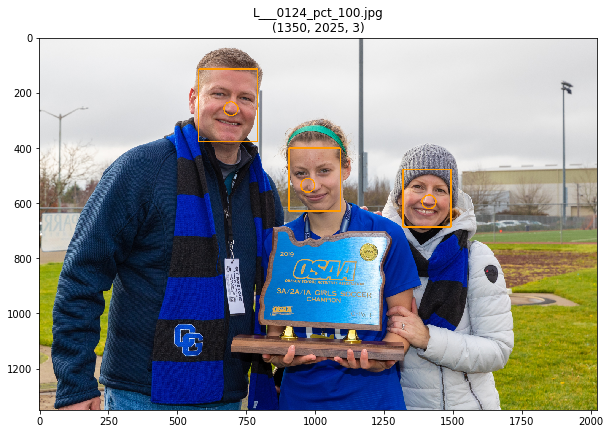

00:00:00


In [8]:
show_errors_gt_ff(k=1, showit=False, plotit=True, filename='L___0124_pct_100.jpg')

The image below  contains 4 correctly found faces and one incorrect face.  The incorrect face is identified by a green square and is actually a soccer ball.

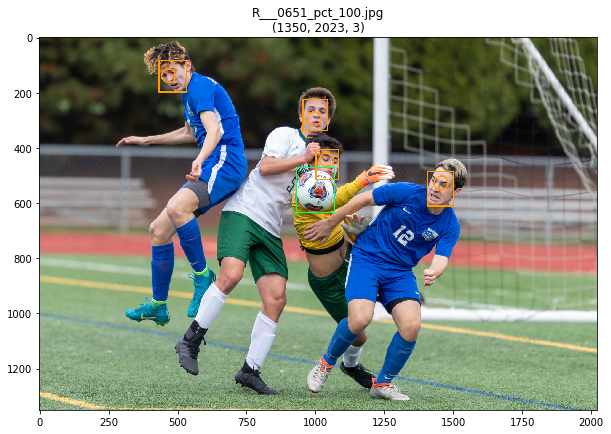

00:00:00


In [9]:
show_errors_gt_ff(k=1, showit=False, plotit=True, filename='R___0651_pct_100.jpg')

The error discussed so far have been "extra" faces identified by the algorthm.  The image below contains two of these errors (green rectangles).  The image also has a face the algorthm did not find (green circle).

Going forward, the "extra faces" (green squares) will be refered to as **false positives** and the missed faces (green circles) will be refered to as **false negatives**.

The image below has 2 false positives, 1 false negative and 19 correctly identified faces.

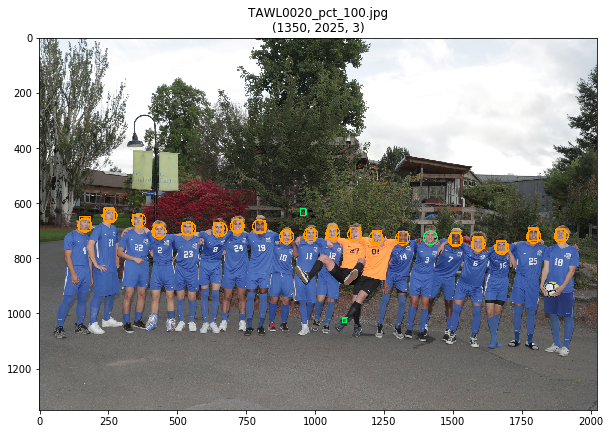

00:00:00


In [10]:
show_errors_gt_ff(k=1, showit=False, plotit=True, filename='TAWL0020_pct_100.jpg')

Below is a summary of the information we have about each image.  It is not critical to understand but it felt appropriate to include for anyone desiring additinal detail.

In [11]:
@time_it
def source_pickle_info(k=1):
    src_pickle_files = [f_name for d_name in Path(faces_mtcnn_path).glob("*") for f_name in d_name.glob('source/*') if d_name.is_dir() if f_name.is_file() if f_name.suffix=='.pkl']
    if k > 0:
        src_pickle_files = random.sample(src_pickle_files, k)
    for src_pickle_file in src_pickle_files: # go through each photo 
        if src_pickle_file.is_file():
            with (open(src_pickle_file, "rb")) as openfile:
                posList = pickle.load(openfile)
                pp.pprint(posList.keys())
                print('')
                pp.pprint(posList)
        else:
            raise ValueError('Pickle file not found 8799')

In [12]:
source_pickle_info()

dict_keys(['ground_truth', 'original_image_info', 'algorithm_faces', 'faces_result'])

{'algorithm_faces': [{'box': [4856, 1869, 98, 122],
                      'confidence': 0.9999902248382568,
                      'confirmed': True,
                      'face_alg_no': '001',
                      'face_file': '..\\..\\data\\04_faces\\04_faces_mtcnn\\2019-09-26\\TAWL0017_pct_100_faceno_001.jpg',
                      'face_gt_no': '019',
                      'gt_found': True,
                      'keypoints': {'left_eye': (4886, 1918),
                                    'mouth_left': (4891, 1967),
                                    'mouth_right': (4928, 1967),
                                    'nose': (4910, 1946),
                                    'right_eye': (4933, 1918)}},
                     {'box': [1800, 1846, 86, 112],
                      'confidence': 0.9999676942825317,
                      'confirmed': True,
                      'face_alg_no': '002',
        

The code below populates a database (Pandas DataFrame) with information for each image and face.  This will be the source information for training our machine learning model.

In [13]:
@time_it
def get_pickle_info(k=1):
    columns = ["box",
                "confidence",
                "keypoints",
                "confirmed",
                "gt_found",
                "face_file",
                "face_alg_no",
                "face_gt_no",
                "dominate_color",
                "average_color",
                "pct_skin_tone"]
    df = pd.DataFrame(columns = columns)
    src_pickle_files = [f_name for d_name in Path(faces_mtcnn_path).glob("*") for f_name in d_name.glob('source/*') if d_name.is_dir() if f_name.is_file() if f_name.suffix=='.pkl']
    if k > 0:
        src_pickle_files = random.sample(src_pickle_files, k)
    for src_pickle_file in src_pickle_files: # go through each photo 
        if src_pickle_file.is_file():
            with (open(src_pickle_file, "rb")) as openfile:
                posList = pickle.load(openfile)
                for kv in posList['algorithm_faces']:  # list so kv is the index of the list
                    entry = {}
                    for i in columns:
                        entry[i] = kv.get(i, None)
                    sidecar_file = Path(entry['face_file'])
                    sidecar_file = (sidecar_file.parent / 'sidecar' / sidecar_file.name).with_suffix('.pkl')
                    with (open(sidecar_file, "rb")) as openfile2:
                        faceDict = pickle.load(openfile2)
                        entry['dominate_color'] = faceDict['face_colors']['dominate_color']
                        entry['average_color'] = faceDict['face_colors']['average_color']
                        entry['pct_skin_tone'] = faceDict['face_colors']['pct_skin_tone']
                    df = df.append(entry, ignore_index=True)
        else:
            raise ValueError('Pickle file not found 8819')
    return df
df = get_pickle_info(-1)

00:00:09


In [14]:
print(f'{"Total algorthum found faces:":<30} {len(df):>10,.0f}')
res = Counter(df['confirmed'])
print(f'{"    Accurate: ":<35} {res[True]:>10,.0f}')
print(f'{"    Inaccurate:":<35} {res[False]:>10,.0f}')

Total algorthum found faces:        1,434
    Accurate:                            1,003
    Inaccurate:                            431


In [15]:
df.head(2)

,box,confidence,keypoints,confirmed,gt_found,face_file,face_alg_no,face_gt_no,dominate_color,average_color,pct_skin_tone
0,"[1327, 1427, 91, 114]",0.999996,"{'left_eye': (1349, 1473), 'right_eye': (1391,...",True,True,..\..\data\04_faces\04_faces_mtcnn\2018-11-10\...,001,003,"(214.44646, 174.45575, 154.9652)","(186.78552149604786, 147.9492963177174, 110.60...",0.816368
1,"[2120, 1257, 128, 163]",0.999988,"{'left_eye': (2151, 1316), 'right_eye': (2211,...",True,True,..\..\data\04_faces\04_faces_mtcnn\2018-11-10\...,002,005,"(190.28212, 136.04692, 113.33043)","(161.37936157975463, 116.35760161042944, 94.88...",0.864695


In [16]:
df[['dominate_color_R','dominate_color_G','dominate_color_B']] = pd.DataFrame(df.dominate_color.tolist())
df[['average_color_R','average_color_G','average_color_B']] = pd.DataFrame(df.average_color.tolist())
df.head(2)

,box,confidence,keypoints,confirmed,gt_found,face_file,face_alg_no,face_gt_no,dominate_color,average_color,pct_skin_tone,dominate_color_R,dominate_color_G,dominate_color_B,average_color_R,average_color_G,average_color_B
0,"[1327, 1427, 91, 114]",0.999996,"{'left_eye': (1349, 1473), 'right_eye': (1391,...",True,True,..\..\data\04_faces\04_faces_mtcnn\2018-11-10\...,001,003,"(214.44646, 174.45575, 154.9652)","(186.78552149604786, 147.9492963177174, 110.60...",0.816368,214.446457,174.455750,154.965195,186.785521,147.949296,110.604010
1,"[2120, 1257, 128, 163]",0.999988,"{'left_eye': (2151, 1316), 'right_eye': (2211,...",True,True,..\..\data\04_faces\04_faces_mtcnn\2018-11-10\...,002,005,"(190.28212, 136.04692, 113.33043)","(161.37936157975463, 116.35760161042944, 94.88...",0.864695,190.282120,136.046921,113.330429,161.379362,116.357602,94.887078


In [17]:
df.columns

Index(['box', 'confidence', 'keypoints', 'confirmed', 'gt_found', 'face_file',
       'face_alg_no', 'face_gt_no', 'dominate_color', 'average_color',
       'pct_skin_tone', 'dominate_color_R', 'dominate_color_G',
       'dominate_color_B', 'average_color_R', 'average_color_G',
       'average_color_B'],
      dtype='object')

Split the data

In [18]:
# split the data

start = time.time()
X = df[['confidence', 'pct_skin_tone', 'dominate_color_R', 'dominate_color_G', 'dominate_color_B', 'average_color_R', 'average_color_G', 'average_color_B']]
print(type(X))
y = np.array(df['confirmed'].astype(int))
print(type(y))

X_train_and_valid, X_test, y_train_and_valid, y_test = train_test_split(
    X, y, test_size=0.1, random_state=50, stratify=y
)
# Separate remainder into training and validation data for optimization
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_and_valid,
    y_train_and_valid,
    test_size=0.2,
    random_state=50,
    stratify=y_train_and_valid,
)

print(f'{"Total Data:":<28}{X.shape[0]:7,.0f}{1:6.0%}  {"X"}')
bl()
print(f'{"Test (holdout) data:":<28}{X_test.shape[0]:7,.0f}{.1:6.0%}  {"X_test"}')
print(
    f'{"Train and Validation data:":<28}{X_train_and_valid.shape[0]:7,.0f}{.9:6.0%}  {"X_train_and_valid"}'
)
bl()
print(f'{"Train data:":<28}{X_train.shape[0]:7,.0f}{.72:6.0%}  {"X_train"}')
print(f'{"Validation data:":<28}{X_valid.shape[0]:7,.0f}{.18:6.0%}  {"X_valid"}')
print(f'{time.strftime("%H:%M:%S", time.gmtime(int(time.time() - start)))}')

<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>
Total Data:                   1,434  100%  X

Test (holdout) data:            144   10%  X_test
Train and Validation data:    1,290   90%  X_train_and_valid

Train data:                   1,032   72%  X_train
Validation data:                258   18%  X_valid
00:00:00


In [19]:
# run the classifiers

start = time.time()
accuracy_score_list = []
f1_score_list = []
precision_score_list = []
recall_score_list = []
roc_auc_score_list = []
models = []

print(f'{"classsifier":<30} {"accuracy":<6}  {"f1_score":<6}  {"precision":<7}    {"recall":<6}   {"roc_auc":<6}  {"time":<15}')

for idx, mod in enumerate(classification_algos):
    start = time.time()
    model = mod
    model.fit(X_train, y_train)
    y_valid_pred = model.predict(X_valid)
    end = time.time()
    recall_score_list.append(recall_score(y_valid, y_valid_pred))
    precision_score_list.append(precision_score(y_valid, y_valid_pred))
    f1_score_list.append(f1_score(y_valid, y_valid_pred))
    accuracy_score_list.append(accuracy_score(y_valid, y_valid_pred))
    roc_auc_score_list.append(roc_auc_score(y_valid, y_valid_pred))

    print(f"{classification_algos_name[idx]:<30} {accuracy_score_list[idx]:>8.2%}  {f1_score_list[idx]:>8.2%}  {precision_score_list[idx]:>9.2%}  {recall_score_list[idx]:>8.2%}  {roc_auc_score_list[idx]:>8.2%}  {end-start:.2f} sec")
print(f'{time.strftime("%H:%M:%S", time.gmtime(int(time.time() - start)))}')

classsifier                    accuracy  f1_score  precision    recall   roc_auc  time           
KNeighborsClassifier             80.62%    87.44%     79.82%    96.67%    70.13%  0.02 sec
GaussianNB                       83.72%    88.77%     85.57%    92.22%    78.16%  0.00 sec
DecisionTreeClassifier           71.71%    79.08%     81.66%    76.67%    68.46%  0.01 sec
ExtraTreeClassifier              75.58%    82.35%     83.05%    81.67%    71.60%  0.00 sec
RandomForestClassifier           86.05%    90.67%     84.95%    97.22%    78.74%  0.26 sec
AdaBoostClassifier               82.17%    87.96%     83.17%    93.33%    74.87%  0.12 sec
GradientBoostingClassifier       84.88%    89.82%     84.73%    95.56%    77.91%  0.27 sec
XGBClassifier                    86.43%    90.96%     85.02%    97.78%    79.02%  0.10 sec
LGBMClassifier                   82.17%    87.63%     84.90%    90.56%    76.69%  0.21 sec
00:00:00


Best classifier: XGBClassifier
00:00:00


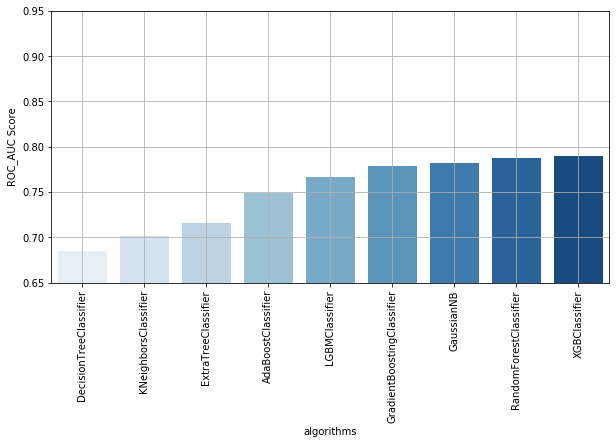

In [20]:
start = time.time()
df_models = pd.DataFrame({"algorithms": classification_algos_name, 
                          "roc_auc": roc_auc_score_list,
                          "recall": recall_score_list,
                          "f1": f1_score_list,
                          "precision": precision_score_list,
                          "accuracy": accuracy_score_list})

df_models.set_index(keys='algorithms', drop=True, inplace=True)
df_models.sort_values(by='roc_auc', ascending=True, inplace=True)
fig, ax = plt.subplots(figsize=(10,5))
ax = sns.barplot(df_models.index, df_models['roc_auc'], palette='Blues')
plt.xticks(rotation=90)
plt.ylim([.65,.95])
plt.ylabel('ROC_AUC Score')
plt.grid(True)

model_best_roc = df_models.index[-1]
print(f'Best classifier: {model_best_roc}')
print(f'{time.strftime("%H:%M:%S", time.gmtime(int(time.time() - start)))}')

In [21]:
start = time.time()
for idx, mod in enumerate(classification_algos):
    if model_best_roc == classification_algos_name[idx]:
        model = mod
        print(f'Selecting {model_best_roc}')
        model.fit(X_train, y_train)
        
if hasattr(model, 'feature_importances_'):
    has_feature_importances_ = True
    print(f'{"":<3}{model_best_roc} has features_importances_')
else:
    has_feature_importances_ = False
    print(f'{"":<3}{model_best_roc} does NOT has features_importances_')

if hasattr(model, 'coef_'):
    has_coef_ = True
    print(f'{"":<3}{model_best_roc} has coef_')
else:
    has_coef_ = False
    print(f'{"":<3}{model_best_roc} does NOT has coef_')
bl()    
print(model)
print(f'{time.strftime("%H:%M:%S", time.gmtime(int(time.time() - start)))}')

Selecting XGBClassifier
   XGBClassifier has features_importances_
   XGBClassifier does NOT has coef_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
00:00:00


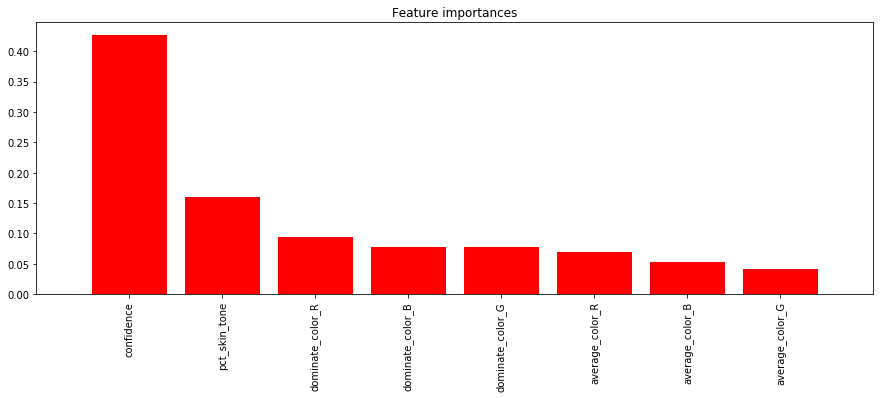

In [22]:
if has_feature_importances_:
    feat_imp_plot(X_train, model, X_train.shape[1], max_features=30)
    plt.show()
    bl()

The baseline score (roc_auc) on the validation set is 86.50%



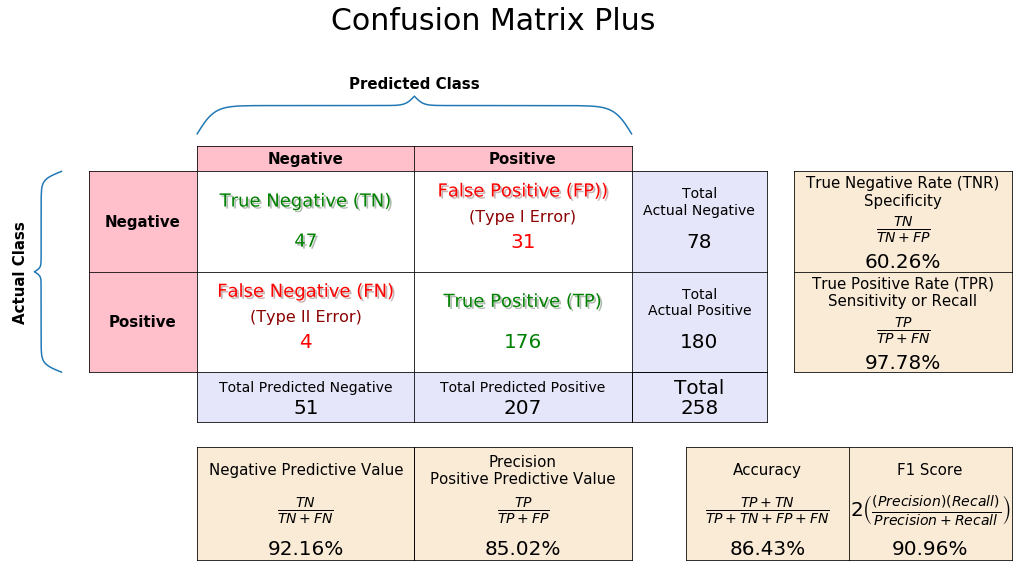

00:00:01


In [23]:
start = time.time()
model.fit(X_train, y_train)

y_pred_prob = model.predict_proba(X_valid)[:, 1]
auc = roc_auc_score(y_valid, y_pred_prob)

print(f'The baseline score (roc_auc) on the validation set is {auc:.2%}')

y_pred_prob = y_pred_prob.reshape(-1,1)
y_pred_class = binarize(y_pred_prob, 0.5)
tn, fp, fn, tp = confusion_matrix(y_valid, y_pred_class).ravel()
# print('\n', classification_report(y_valid, y_pred_class, digits=4), '\n');
_ = plot_cm_plus(tn=tn, fp=fp, fn=fn, tp=tp)
print(f'{time.strftime("%H:%M:%S", time.gmtime(int(time.time() - start)))}')

Optimal cutoff: 66.46%
00:00:00


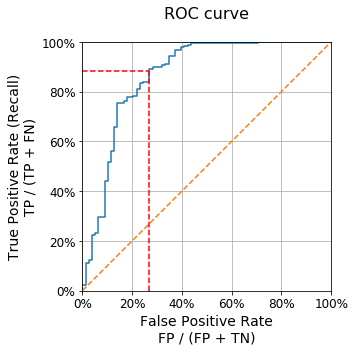

In [24]:
start = time.time()
cutoff = plot_roc_curve(y_valid, y_pred_prob);
plt.plot()
print(f'Optimal cutoff: {cutoff:.2%}')
print(f'{time.strftime("%H:%M:%S", time.gmtime(int(time.time() - start)))}')

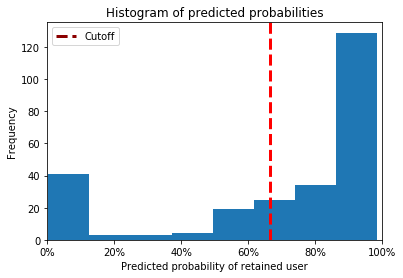

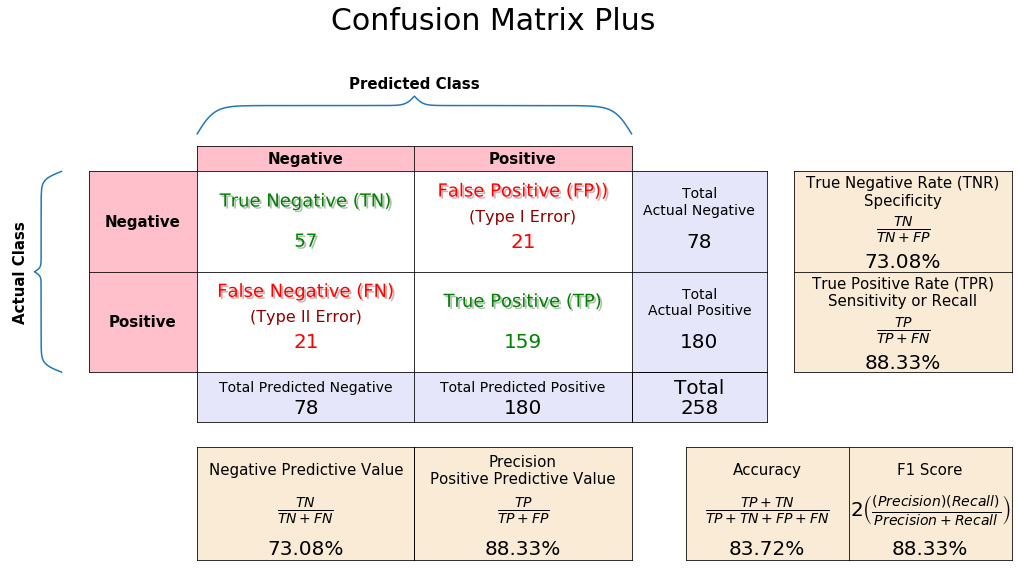


00:00:01


In [25]:
start = time.time()
y_pred_class = binarize(y_pred_prob.reshape(-1,1), cutoff)
tn, fp, fn, tp = confusion_matrix(y_valid, y_pred_class).ravel()
pred_prob_hist(X_valid, bins=8, xlabel='retained user', cutoff=cutoff)
# print('\n', classification_report(y_valid, y_pred_class, digits=4), '\n')
_ = plot_cm_plus(tn=tn, fp=fp, fn=fn, tp=tp)
bl()
print(f'{time.strftime("%H:%M:%S", time.gmtime(int(time.time() - start)))}')

**NOTE: Update numbers on final run**
The MTCNN computer algorthm identified all 258 data points as faces.  We know that 180 are actually faces and 78 are not faces.  Looking at the optimized confusion matrix above, there are 23 False Positives which means after training, we have 21 faces identified that are not truly faces.  We also have 18 False Negatives which means we have 18 actual faces that are not identified.  We want to be very careful here and really minimize Type II Errors.  This problem requires we take a different approach for optimizing our cutoff value.

Let's examine results from cutoff values from 1% to 100%.

In [26]:
start = time.time()
columns = ['cutoff', 'True Negative', 'False Positive', 'False Negative', 'True Positive']
df_1 = pd.DataFrame(columns=columns)
entry={}
for i in range(100):
    cutoff = i / 100
    y_pred_class = binarize(y_pred_prob.reshape(-1,1), cutoff)
    tn, fp, fn, tp = confusion_matrix(y_valid, y_pred_class).ravel()
    entry['cutoff'] = cutoff * 100
    entry['True Negative'] = tn
    entry['False Positive'] = fp
    entry['False Negative'] = fn
    entry['True Positive'] = tp
    df_1 = df_1.append(entry, ignore_index=True)
df_1 = df_1.set_index('cutoff', drop=True)
print(f'{time.strftime("%H:%M:%S", time.gmtime(int(time.time() - start)))}')

00:00:00


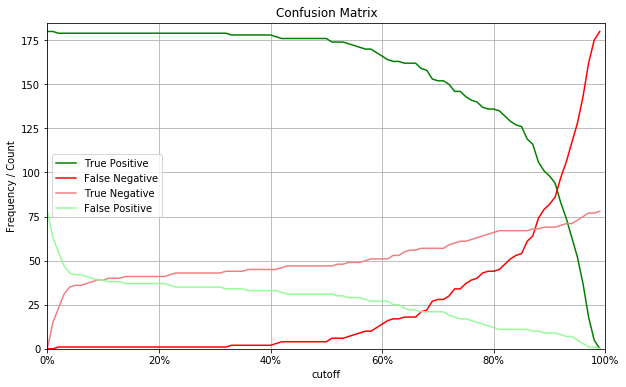

In [27]:
fig, ax = plt.subplots(figsize=(10,6), subplot_kw={'ylim': (0,185), 'xlim': (0,100), 'title': 'Confusion Matrix', 'xlabel':'Cutoff', 'ylabel':'Frequency / Count'})
df_1[['True Positive','False Negative','True Negative','False Positive']].plot(ax=ax, grid=True, color=['g', 'r', 'lightcoral', 'palegreen'])
ax.xaxis.set_major_formatter(PercentFormatter())

**NOTE:  text describing how I picked 46% and the graphs below**

In [28]:
_cutoff = 46
_tn, _fp, _fn, _tp = df_1.iloc[46]

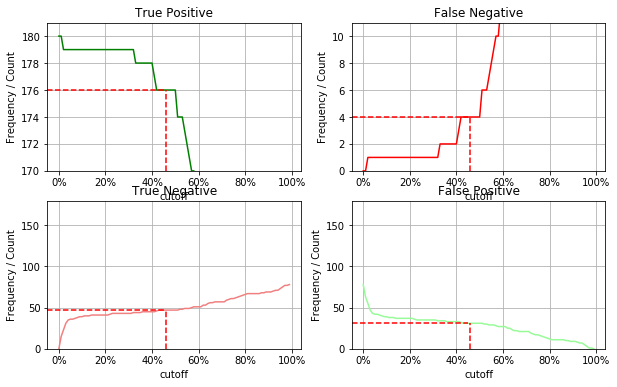

In [29]:
fig, axs = plt.subplots(2,2,figsize=(10,6), subplot_kw={'ylim': (0,181), 'ylabel':'Frequency / Count'})
ax = axs.flatten()
colors = ['g', 'r', 'lightcoral', 'palegreen']
y_limits = [(170,181), (0,11), (0,180), (0,180)]
result =  [('True Positive', _tp), ('False Negative', _fn), ('True Negative', _tn), ('False Positive', _fp)]
for i, c in enumerate(result):
    df_1[[c[0]]].plot(ax = ax[i], color=colors[i], grid=True, title=str(c[0]), legend=False)
    yminz = y_limits[i][0]
    ymaxz = y_limits[i][1]
    ax[i].set_ylim(yminz, ymaxz)
    ax[i].xaxis.set_major_formatter(PercentFormatter())
    ax[i].axvline(x=_cutoff, ymin=0, ymax=((c[1]-yminz)/(ymaxz-yminz)), color='r', linestyle='--')
    ax[i].axhline(y=c[1], xmin=0, xmax=_cutoff/100, color='r', linestyle='--')

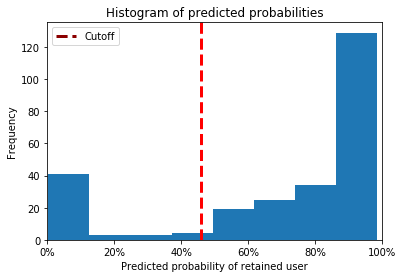

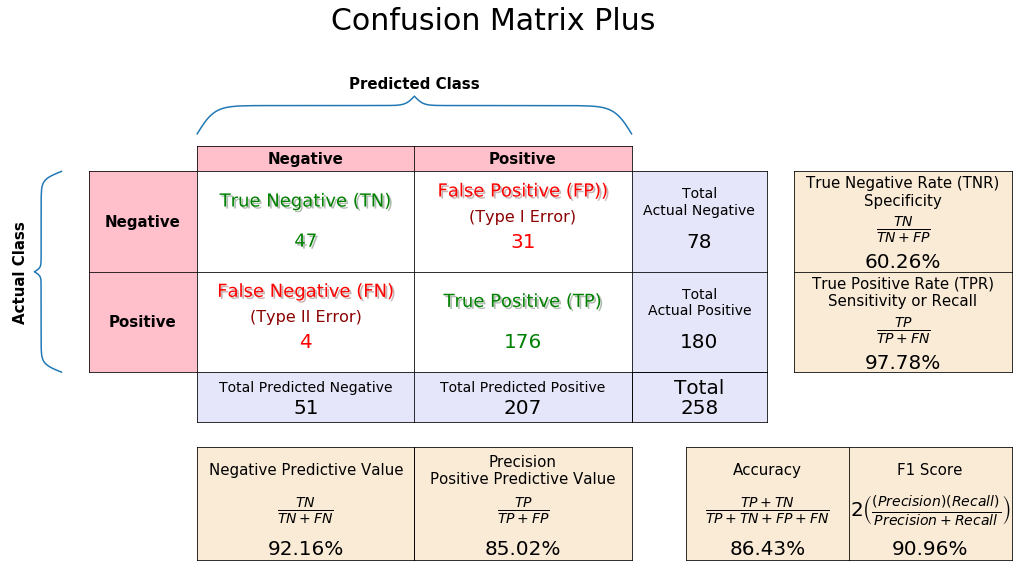


00:00:01


In [30]:
cutoff = .46
start = time.time()
y_pred_class = binarize(y_pred_prob.reshape(-1,1), cutoff)
tn, fp, fn, tp = confusion_matrix(y_valid, y_pred_class).ravel()
pred_prob_hist(X_valid, bins=8, xlabel='retained user', cutoff=cutoff)
# print('\n', classification_report(y_valid, y_pred_class, digits=4), '\n')
_ = plot_cm_plus(tn=tn, fp=fp, fn=fn, tp=tp)
bl()
print(f'{time.strftime("%H:%M:%S", time.gmtime(int(time.time() - start)))}')

Refit model with train and valid data...

In [31]:
start = time.time()
model.fit(X_train_and_valid, y_train_and_valid)
print(f'{time.strftime("%H:%M:%S", time.gmtime(int(time.time() - start)))}')

00:00:00


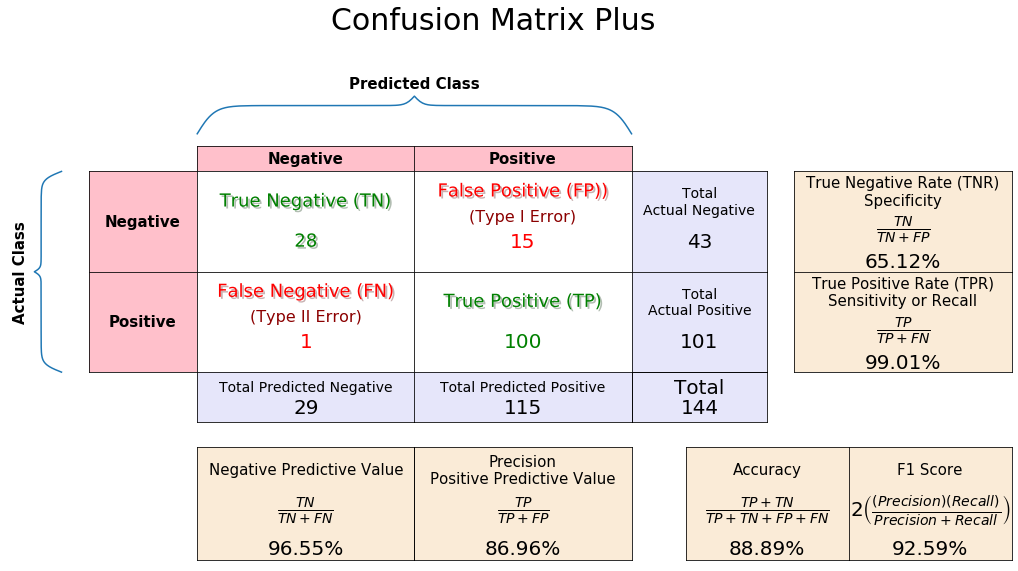


00:00:01


In [32]:
start = time.time()
y_pred_prob = model.predict_proba(X_test)[:, 1]
y_pred_class = binarize(y_pred_prob.reshape(-1,1), cutoff)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_class).ravel()
# print('\n', classification_report(y_test, y_pred_class, digits=4), '\n')
fig = plot_cm_plus(tn=tn, fp=fp, fn=fn, tp=tp)
fig.savefig('images/Optimize_cutoff_value')
bl()
print(f'{time.strftime("%H:%M:%S", time.gmtime(int(time.time() - start)))}')

In [33]:
start = time.time()
time.sleep(1)
print(f'{time.strftime("%H:%M:%S", time.gmtime(int(time.time() - start)))}')

00:00:01


In [34]:
print(f'{time.strftime("%H:%M:%S", time.gmtime(int(time.time() - start_all)))}')

00:00:21
